---
Lógica Computacional TP1.Exercício2
======================
##### G01 - Bruno Dias da Gião A96544, João Luis da Cruz Pereira A95375, David Alberto Agra A95726


---

## Exercício 2 - Enunciado

2. Um sistema de tráfego  é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e  os arcos denotam vias de comunicação só com um sentido .  O grafo tem de ser ligado: entre cada par de nodos $\langle n_1,n_2 \rangle$ tem de existir um caminho $n_1 \leadsto n_2$ e um caminho $n_2\leadsto n_1$.
    1. Gerar aleatoriamente o grafo com  $N \in\{8..15\}$  nodos e com ramos verificando:
        1. Cada nodo tem um número aleatório de descendentes $d\in\{0 .. 3\}\,$ cujos destinos são também gerados aleatoriamente. 
        2. Se existirem “loops”  ou destinos repetidos, deve-se gerar outro grafo.
    2. Pretende-se fazer manutenção interrompendo  determinadas vias. Determinar o maior número de vias que é possível remover mantendo o grafo ligado.

---

## Exercício 2 - Solução

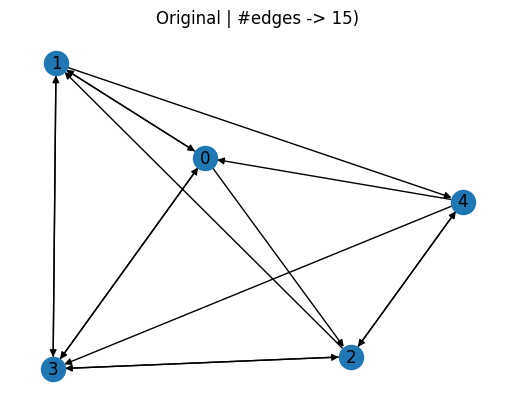

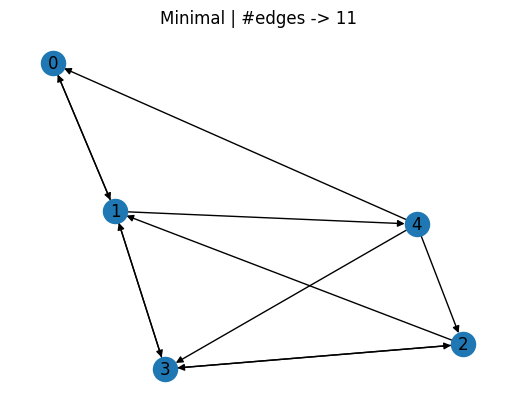

In [63]:
from ortools.linear_solver import pywraplp
import networkx as nx
import random

# Create an empty directed graph with 10 nodes
N = 5
G = nx.DiGraph()
G.add_nodes_from(range(N))

# Randomly add edges while ensuring strong connectivity and at most 3 neighbors per node
max_neighbors = 3
nodes = list(G.nodes())
for node in nodes:
    neighbors = set(G.neighbors(node))
    while len(neighbors) < max_neighbors:
        target_node = random.choice(nodes)
        if target_node != node and target_node not in neighbors:
            G.add_edge(node, target_node)
            neighbors.add(target_node)

solver = pywraplp.Solver.CreateSolver('SCIP')

edge_vars = {}

for u, v in G.edges():
    edge_vars[u, v] = solver.IntVar(0, 1, f'edge_{u}_{v}')

objective = solver.Objective()

for u, v in edge_vars:
    objective.SetCoefficient(edge_vars[u, v], -1)

objective.SetMaximization()

for u, v in edge_vars:
    const = solver.Constraint(1, solver.infinity())
    for i in G.nodes():
        if (i, v) in edge_vars:
            const.SetCoefficient(edge_vars[i, v], 1)
        if (u, i) in edge_vars:
            const.SetCoefficient(edge_vars[u, i], 1)

s = solver.Solve()

import matplotlib.pyplot as plt
pos = nx.spring_layout(G)
plt.title(f'Original | #edges -> {len(edge_vars)})')
nx.draw(G, pos, with_labels=True, node_size=300)
plt.show()

for u, v in edge_vars:
    if edge_vars[u, v].solution_value() == 1:
        G.remove_edge(u, v)
plt.title(f'Minimal | #edges -> {len(G.edges())}')
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=300)
plt.show()


### Exercício 2 - Código

### Exercício 2 - Testes